In [23]:
import pandas as pd


df = pd.read_csv('../data/players_data-2024_2025.csv')

print(df.shape)
df.head()


(2854, 267)


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Att (GK),Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,24.0,2000.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Max Aarons,eng ENG,"DF,MF",Valencia,es La Liga,24.0,2000.0,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,21.0,2003.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,20.0,2004.0,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,18.0,2006.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Chargement des données brutes et ajout de la colonne "style"

In [116]:
import pandas as pd
import numpy as np

# Charger le fichier brut
df = pd.read_csv("../data/players_clean.csv")

# Colonnes à utiliser
features = ['Gls', 'Ast', 'xG', 'xAG', 'Tkl', 'PrgP', 'Carries', 'KP']

# S'assurer que la colonne 'style' existe
if 'style' not in df.columns:
    df['style'] = ""

# Remplacer les valeurs manquantes dans les features par 0
df[features] = df[features].fillna(0)


Remplir colonne Style

In [118]:
# Joueurs de champ uniquement (hors gardiens)
field_players = df[(~df['Pos'].str.contains("GK", na=False)) & (df['PrgP'] > 0)]

quantiles = {
    'Gls':  {'high': field_players['Gls'].quantile(0.80), 'top': field_players['Gls'].quantile(0.95)},
    'Ast':  {'high': field_players['Ast'].quantile(0.80), 'top': field_players['Ast'].quantile(0.95)},
    'xG':   {'median': field_players['xG'].quantile(0.50), 'high': field_players['xG'].quantile(0.85), 'top': field_players['xG'].quantile(0.95)},
    'xAG':  {'median': field_players['xAG'].quantile(0.50), 'high': field_players['xAG'].quantile(0.85), 'top': field_players['xAG'].quantile(0.95)},
    'Tkl':  {'median': field_players['Tkl'].quantile(0.50), 'high': field_players['Tkl'].quantile(0.85), 'top': field_players['Tkl'].quantile(0.95)},
    'PrgP': {'low': field_players['PrgP'].quantile(0.25), 'median': field_players['PrgP'].quantile(0.50), 'high': field_players['PrgP'].quantile(0.85), 'top': field_players['PrgP'].quantile(0.95)},
    'KP':   {'low': field_players['KP'].quantile(0.25), 'median': field_players['KP'].quantile(0.50), 'high': field_players['KP'].quantile(0.85), 'top': field_players['KP'].quantile(0.95)},
    'Carries': {'high': field_players['Carries'].quantile(0.85)}
}

# Fonction d'attribution
def attribuer_style_equilibre(row):
    if 'GK' in row['Pos']:
        return "Gardien"

    pos = row['Pos']
    gls, ast, xg, xag = row['Gls'], row['Ast'], row['xG'], row['xAG']
    tkl, prgp, carries, kp = row['Tkl'], row['PrgP'], row['Carries'], row['KP']

    if pos.startswith("DF") and tkl > quantiles['Tkl']['top'] and prgp < quantiles['PrgP']['low']:
        return "Defensif"
    
    if xg > quantiles['xG']['high'] and xag > quantiles['xAG']['high'] and prgp > quantiles['PrgP']['high'] and tkl > quantiles['Tkl']['median']:
        return "Football total"

    if kp > quantiles['KP']['top'] and prgp > quantiles['PrgP']['top']:
        return "Jeu de possession"

    if tkl > quantiles['Tkl']['top'] and (xg + xag) < quantiles['xG']['high']:
        return "Pressing intense"

    if prgp > quantiles['PrgP']['high'] and kp > quantiles['KP']['high'] and xag > quantiles['xAG']['high']:
        return "Jeu positionnel"

    if carries > quantiles['Carries']['high'] and prgp < quantiles['PrgP']['median']:
        return "Jeu direct"

    return ""  # Pas assez d'informations pour décider


Séparer les joueurs labellisés et non-labellisés

In [121]:
# Appliquer la fonction d'attribution
df['style'] = df.apply(attribuer_style_equilibre, axis=1)

# Créer deux DataFrames
df_train = df[df['style'] != ""].copy()   # Avec style (pour entraînement)
df_unknown = df[df['style'] == ""].copy() # Sans style (pour prédiction)


Entrainement

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Définir X et y
X = df_train[features]
y = df_train['style']

# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entraînement
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
print("✅ Précision :", accuracy_score(y_test, y_pred))
print("\n📊 Rapport de classification :\n")
print(classification_report(y_test, y_pred))


✅ Précision : 0.9411764705882353

📊 Rapport de classification :

                   precision    recall  f1-score   support

   Football total       0.86      0.95      0.90        20
          Gardien       1.00      1.00      1.00        38
Jeu de possession       1.00      0.50      0.67         4
  Jeu positionnel       0.86      0.86      0.86        14
 Pressing intense       1.00      1.00      1.00         9

         accuracy                           0.94        85
        macro avg       0.94      0.86      0.89        85
     weighted avg       0.94      0.94      0.94        85



Predire pour les autres joueurs

In [131]:
# Prédiction sur les joueurs non labellisés
X_unknown = df_unknown[features].fillna(0)
df_unknown['style'] = model.predict(X_unknown)


Fusion final et sauvegarde

In [133]:
# Fusion des deux DataFrames
df_final = pd.concat([df_train, df_unknown])

# Sauvegarde
df_final.to_csv("../data/players_with_predicted_styles.csv", index=False)
print("✅ Fichier final sauvegardé avec tous les styles prédits.")


✅ Fichier final sauvegardé avec tous les styles prédits.


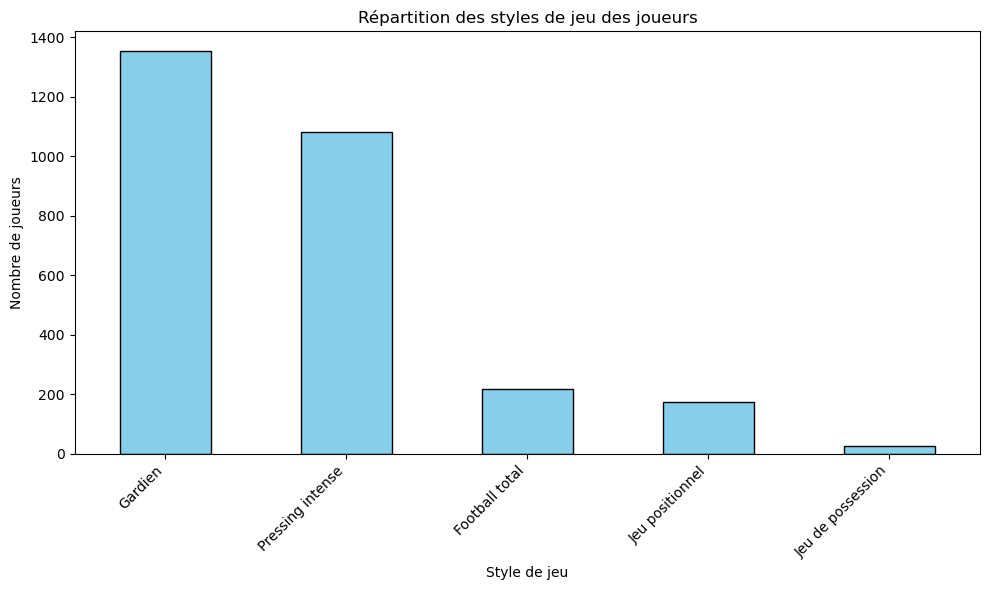

In [135]:
import matplotlib.pyplot as plt

# Compter le nombre de joueurs par style
style_counts = df_final['style'].value_counts()

# Création du graphique
plt.figure(figsize=(10, 6))
style_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Répartition des styles de jeu des joueurs")
plt.xlabel("Style de jeu")
plt.ylabel("Nombre de joueurs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Affichage
plt.show()


✅ Précision : 0.9770114942528736

📊 Rapport de classification :

                   precision    recall  f1-score   support

   Football total       1.00      1.00      1.00        12
          Gardien       1.00      1.00      1.00        43
Jeu de possession       0.60      1.00      0.75         3
  Jeu positionnel       1.00      0.88      0.93        16
 Pressing intense       1.00      1.00      1.00        13

         accuracy                           0.98        87
        macro avg       0.92      0.97      0.94        87
     weighted avg       0.99      0.98      0.98        87

✅ Données finales enregistrées avec style et valeur marchande.


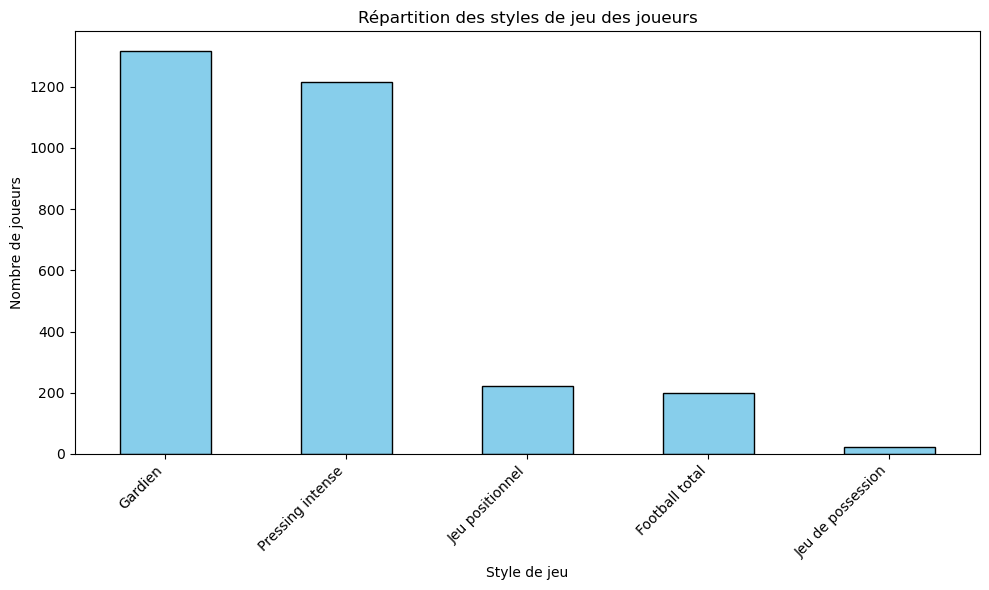

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# === 1. Charger ton fichier principal ===
df = pd.read_csv("../data/players_clean.csv")

# === 2. Charger le fichier avec les valeurs marchandes ===
df_value = pd.read_csv("../data/players.csv")

# === 3. Créer la colonne 'Player' en combinant first_name et last_name ===
df_value['first_name'] = df_value['first_name'].fillna("")
df_value['last_name'] = df_value['last_name'].fillna("")
df_value['Player'] = (df_value['first_name'] + " " + df_value['last_name']).str.strip()

# Garder seulement les colonnes utiles
df_value = df_value[['Player', 'market_value_in_eur']]
df_value.rename(columns={"market_value_in_eur": "MarketValue"}, inplace=True)

# === 4. Nettoyer les noms dans les deux datasets (optionnel mais utile) ===
df['Player'] = df['Player'].str.strip().str.lower()
df_value['Player'] = df_value['Player'].str.strip().str.lower()

# === 5. Fusionner sur le nom du joueur ===
df = df.merge(df_value, on='Player', how='left')
df['MarketValue'] = df['MarketValue'].fillna(0)

# === 6. Préparer les features ===
features = ['Gls', 'Ast', 'xG', 'xAG', 'Tkl', 'PrgP', 'Carries', 'KP']
df[features] = df[features].fillna(0)
if 'style' not in df.columns:
    df['style'] = ""

# === 7. Calcul des quantiles ===
field_players = df[(~df['Pos'].str.contains("GK", na=False)) & (df['PrgP'] > 0)]

quantiles = {
    'Gls':  {'high': field_players['Gls'].quantile(0.80), 'top': field_players['Gls'].quantile(0.95)},
    'Ast':  {'high': field_players['Ast'].quantile(0.80), 'top': field_players['Ast'].quantile(0.95)},
    'xG':   {'median': field_players['xG'].quantile(0.50), 'high': field_players['xG'].quantile(0.85), 'top': field_players['xG'].quantile(0.95)},
    'xAG':  {'median': field_players['xAG'].quantile(0.50), 'high': field_players['xAG'].quantile(0.85), 'top': field_players['xAG'].quantile(0.95)},
    'Tkl':  {'median': field_players['Tkl'].quantile(0.50), 'high': field_players['Tkl'].quantile(0.85), 'top': field_players['Tkl'].quantile(0.95)},
    'PrgP': {'low': field_players['PrgP'].quantile(0.25), 'median': field_players['PrgP'].quantile(0.50), 'high': field_players['PrgP'].quantile(0.85), 'top': field_players['PrgP'].quantile(0.95)},
    'KP':   {'low': field_players['KP'].quantile(0.25), 'median': field_players['KP'].quantile(0.50), 'high': field_players['KP'].quantile(0.85), 'top': field_players['KP'].quantile(0.95)},
    'Carries': {'high': field_players['Carries'].quantile(0.85)}
}

# === 8. Fonction d'attribution du style ===
def attribuer_style_equilibre(row):
    if 'GK' in row['Pos']:
        return "Gardien"
    pos = row['Pos']
    gls, ast, xg, xag = row['Gls'], row['Ast'], row['xG'], row['xAG']
    tkl, prgp, carries, kp = row['Tkl'], row['PrgP'], row['Carries'], row['KP']
    
    if pos.startswith("DF") and tkl > quantiles['Tkl']['top'] and prgp < quantiles['PrgP']['low']:
        return "Defensif"
    if xg > quantiles['xG']['high'] and xag > quantiles['xAG']['high'] and prgp > quantiles['PrgP']['high'] and tkl > quantiles['Tkl']['median']:
        return "Football total"
    if kp > quantiles['KP']['top'] and prgp > quantiles['PrgP']['top']:
        return "Jeu de possession"
    if tkl > quantiles['Tkl']['top'] and (xg + xag) < quantiles['xG']['high']:
        return "Pressing intense"
    if prgp > quantiles['PrgP']['high'] and kp > quantiles['KP']['high'] and xag > quantiles['xAG']['high']:
        return "Jeu positionnel"
    if carries > quantiles['Carries']['high'] and prgp < quantiles['PrgP']['median']:
        return "Jeu direct"
    return ""

# === 9. Appliquer la fonction d’attribution ===
df['style'] = df.apply(attribuer_style_equilibre, axis=1)

# === 10. Entraînement du modèle ===
df_train = df[df['style'] != ""].copy()
df_unknown = df[df['style'] == ""].copy()

X = df_train[features]
y = df_train['style']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# === 11. Prédiction et évaluation ===
y_pred = model.predict(X_test)
print("✅ Précision :", accuracy_score(y_test, y_pred))
print("\n📊 Rapport de classification :\n")
print(classification_report(y_test, y_pred))

# === 12. Prédire le style pour les joueurs inconnus ===
X_unknown = df_unknown[features].fillna(0)
df_unknown['style'] = model.predict(X_unknown)

# === 13. Fusion et sauvegarde ===
df_final = pd.concat([df_train, df_unknown])
df_final.to_csv("../data/players_with_predicted_styles_and_market_value.csv", index=False)
print("✅ Données finales enregistrées avec style et valeur marchande.")

# === 14. Visualisation ===
style_counts = df_final['style'].value_counts()
plt.figure(figsize=(10, 6))
style_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Répartition des styles de jeu des joueurs")
plt.xlabel("Style de jeu")
plt.ylabel("Nombre de joueurs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [159]:
def filtrer_joueurs(df, style=None, position=None, budget_max=None, top_n=10):
    """Filtre les joueurs selon style, position et budget."""
    filtres = df.copy()

    if style:
        filtres = filtres[filtres['style'].str.lower() == style.lower()]
    if position:
        filtres = filtres[filtres['Pos'].str.contains(position.upper(), na=False)]
    if budget_max is not None:
        filtres = filtres[filtres['MarketValue'] <= budget_max]
    
    filtres = filtres.sort_values(by="MarketValue", ascending=False)
    return filtres[['Player', 'Pos', 'style', 'MarketValue']].head(top_n)


In [161]:
# Exemple : trouver 10 joueurs pour une équipe qui joue "Jeu de possession",
# cherchant des milieux de terrain (MF), avec un budget max de 15 millions d'euros

joueurs_suggérés = filtrer_joueurs(
    df_final,
    style="Jeu de possession",
    position="MF",
    budget_max=100_000_000,
    top_n=10
)

print(joueurs_suggérés)


                   Player    Pos              style  MarketValue
1633  alexis mac allister     MF  Jeu de possession   90000000.0
248        nicolò barella     MF  Jeu de possession   80000000.0
1428       joshua kimmich     MF  Jeu de possession   50000000.0
2614       angelo stiller     MF  Jeu de possession   38000000.0
553          rayan cherki  FW,MF  Jeu de possession   35000000.0
2704      youri tielemans     MF  Jeu de possession   35000000.0
707       kevin de bruyne  MF,FW  Jeu de possession   27000000.0
667      mikkel damsgaard  MF,FW  Jeu de possession   25000000.0
2912         granit xhaka     MF  Jeu de possession   17000000.0
608            lewis cook  MF,DF  Jeu de possession   15000000.0
